<div style="text-align: right"><b> Ana Valentina López Chacón </b></div>
<div style="text-align: right"><b> Reconocimiento de Formas, 2024 - 2025 </b></div>

## **Clasificación de Animales: Regularización**

In [1]:
!pip install keras_tuner --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
import keras_tuner
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
keras.utils.set_random_seed(23)



Realizamos la lectura de los datos.

In [3]:
dataset_path = '/kaggle/input/animals10/raw-img'

IMG_SIZE = (64, 64)
BATCH_SIZE = 32
num_clases = 10

train_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

test_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

validation_split = 0.25  
num_validation_batches = int(validation_split * len(train_dataset)) #.file_paths
validation_dataset = train_dataset.take(num_validation_batches)
train_dataset = train_dataset.skip(num_validation_batches)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


Definimos el espacio de busqueda para el keras tuner y realizamos las pruebas.

In [4]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        M = keras.Sequential()
        M.add(keras.Input(shape=(64,64,3)))
        M.add(keras.layers.Rescaling(scale = 1/255))
        filters = 32
        penalidad = hp.Float("penalidad", min_value=0.01, max_value=0.05, step=0.01)
        M.add(keras.layers.Conv2D(filters, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(penalidad)))
        M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        M.add(keras.layers.Conv2D(2*filters, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(penalidad)))
        M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        M.add(keras.layers.Conv2D(4*filters, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(penalidad)))
        M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
        M.add(keras.layers.Flatten())
        dropout = hp.Float("dropout", min_value=0.05, max_value=0.3, step=0.05)
        M.add(keras.layers.Dense(units=4096, activation='relu'))
        M.add(keras.layers.Dropout(dropout))
        M.add(keras.layers.Dense(units=256, activation='relu'))
        M.add(keras.layers.Dropout(dropout/2))
        M.add(keras.layers.Dense(units=64, activation='relu'))
        M.add(keras.layers.Dense(10, activation='softmax'))
        opt = keras.optimizers.Adam(learning_rate=0.001)
        M.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["SparseCategoricalAccuracy"])
        return M
    def fit(self, hp, M, xy, xy_val, **kwargs):
        factor = 0.2585
        patience = 5
        reduce_cb = keras.callbacks.ReduceLROnPlateau(
        monitor='val_SparseCategoricalAccuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
        early_cb = keras.callbacks.EarlyStopping(monitor='val_SparseCategoricalAccuracy', patience=patience, min_delta=1e-5)
        kwargs['callbacks'].extend([reduce_cb, early_cb])
        return M.fit(xy, batch_size=128, epochs=100, validation_data=xy_val, **kwargs)


In [5]:
tuner = keras_tuner.BayesianOptimization(MyHyperModel(), 
                                         objective="val_SparseCategoricalAccuracy", 
                                         max_trials = 5, 
                                         executions_per_trial = 1,
                                         overwrite=True)

In [6]:
tuner.search(train_dataset, validation_dataset)

Trial 5 Complete [00h 08m 02s]
val_SparseCategoricalAccuracy: 0.6125383377075195

Best val_SparseCategoricalAccuracy So Far: 0.6125383377075195
Total elapsed time: 00h 29m 50s


In [7]:
tuner.results_summary(num_trials = 1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_SparseCategoricalAccuracy", direction="max")

Trial 4 summary
Hyperparameters:
penalidad: 0.03
dropout: 0.2
Score: 0.6125383377075195


In [8]:
num_models = 5
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=num_models)
best_models = tuner.get_best_models(num_models=num_models)
for m in range(num_models):
 values = best_hyperparameters[m].values
 score = best_models[m].evaluate(test_dataset, verbose=0)
 print(f'Model {m}: Hyperparameters: {values!s} Loss: {score[0]:.4} Precisión: {score[1]:.2%}')


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model 0: Hyperparameters: {'penalidad': 0.03, 'dropout': 0.2} Loss: 1.24 Precisión: 60.11%
Model 1: Hyperparameters: {'penalidad': 0.02, 'dropout': 0.1} Loss: 1.296 Precisión: 57.59%
Model 2: Hyperparameters: {'penalidad': 0.04, 'dropout': 0.25} Loss: 1.495 Precisión: 49.07%
Model 3: Hyperparameters: {'penalidad': 0.04, 'dropout': 0.2} Loss: 1.65 Precisión: 45.00%
Model 4: Hyperparameters: {'penalidad': 0.03, 'dropout': 0.15000000000000002} Loss: 1.766 Precisión: 39.73%


In [9]:
M = keras.Sequential()
M.add(keras.Input(shape=(64,64,3)))
M.add(keras.layers.Rescaling(scale = 1/255))
filters = 32
penalidad = 0.02
M.add(keras.layers.Conv2D(filters, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(penalidad)))
M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
M.add(keras.layers.Conv2D(2*filters, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(penalidad)))
M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
M.add(keras.layers.Conv2D(4*filters, kernel_size=(3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(penalidad)))
M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
M.add(keras.layers.Flatten())
dropout = 0.1
M.add(keras.layers.Dense(units=4096, activation='relu'))
M.add(keras.layers.Dropout(dropout))
M.add(keras.layers.Dense(units=256, activation='relu'))
M.add(keras.layers.Dropout(dropout/2))
M.add(keras.layers.Dense(units=64, activation='relu'))
M.add(keras.layers.Dense(10, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.001)
M.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["SparseCategoricalAccuracy"])
factor = 0.2585
patience = 5
reduce_cb = keras.callbacks.ReduceLROnPlateau(
        monitor='val_SparseCategoricalAccuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
early_cb = keras.callbacks.EarlyStopping(monitor='val_SparseCategoricalAccuracy', patience=patience, min_delta=1e-5)
H = M.fit(train_dataset, batch_size=128, epochs=100, validation_data=validation_dataset, verbose=1, callbacks = [reduce_cb, early_cb])

Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - SparseCategoricalAccuracy: 0.2226 - loss: 2.7220 - val_SparseCategoricalAccuracy: 0.3000 - val_loss: 2.0277 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - SparseCategoricalAccuracy: 0.3132 - loss: 1.9910 - val_SparseCategoricalAccuracy: 0.3677 - val_loss: 1.8477 - learning_rate: 0.0010
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - SparseCategoricalAccuracy: 0.3715 - loss: 1.8294 - val_SparseCategoricalAccuracy: 0.4264 - val_loss: 1.6949 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - SparseCategoricalAccuracy: 0.4287 - loss: 1.6950 - val_SparseCategoricalAccuracy: 0.4540 - val_loss: 1.6204 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - SparseCategoricalAccuracy: 0.4569 - loss: 1.6034 - val_SparseCategoricalAccuracy: 0.4668 - val_loss: 1.6122 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step 

In [10]:
score = M.evaluate(test_dataset, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 1.284
Precisión: 58.47%


Realizamos la gráfica para losses, accuracy, matriz de confusión y reporte de clasificación.

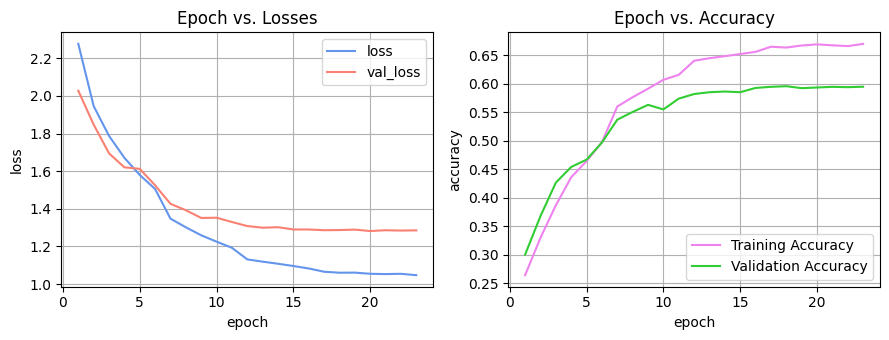

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Epoch vs. Losses")
# ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], label = 'loss', color='cornflowerblue')
ax.plot(xx, H.history['val_loss'], label = 'val_loss', color='salmon')
ax.legend()

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title("Epoch vs. Accuracy")
# ax.set_xticks(xx)
ax.plot(xx, H.history['SparseCategoricalAccuracy'], label='Training Accuracy', color='violet')
ax.plot(xx, H.history['val_SparseCategoricalAccuracy'], label='Validation Accuracy', color = 'limegreen')
ax.legend()
plt.tight_layout()

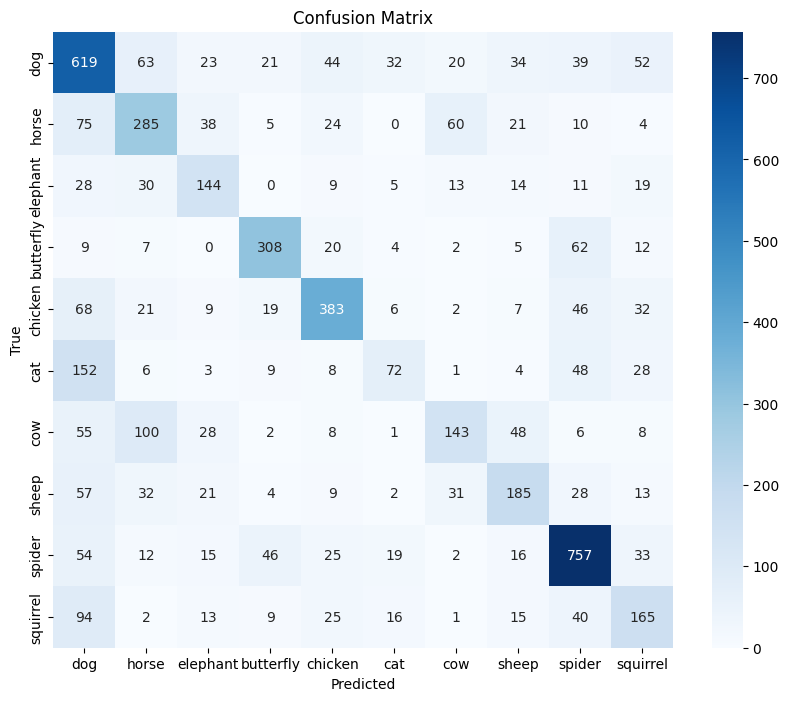

              precision    recall  f1-score   support

         dog       0.51      0.65      0.57       947
       horse       0.51      0.55      0.53       522
    elephant       0.49      0.53      0.51       273
   butterfly       0.73      0.72      0.72       429
     chicken       0.69      0.65      0.67       593
         cat       0.46      0.22      0.30       331
         cow       0.52      0.36      0.42       399
       sheep       0.53      0.48      0.51       382
      spider       0.72      0.77      0.75       979
    squirrel       0.45      0.43      0.44       380

    accuracy                           0.58      5235
   macro avg       0.56      0.54      0.54      5235
weighted avg       0.58      0.58      0.58      5235



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_labels_and_predictions(dataset, model):
    true_labels = []
    predictions = []

    for images, labels in dataset:
        preds = model.predict(images, verbose = 0)
        predicted_classes = np.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        predictions.extend(predicted_classes)

    return np.array(true_labels), np.array(predictions)

true_labels, predicted_labels = get_labels_and_predictions(test_dataset, M)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
              "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
class_names = [translate[i] for i in test_dataset.class_names]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names = class_names))

## **Resumen de Resultados**

- Con el MLP sencillo obtenemos una precisión del 36.6%.
- Usando el Keras Tuner para la arquitectura de red obtenemos una precisión del 37.1%.
- Al realizar el ajuste del Learning rate y BatchSize obtenemos una precisión del 37.19%.
- Al incluir ReduceOnPlateau en los callbacks obtenemos una precisión del 41.47%.
- Con capas convolucionales y de pooling la precisión sube a un 67.47%, sin embargo se presenta mucho overfitting.
- Al realizar una penalización de pesos L2 al igual que añadiendo un componente de dropout se obtiene una precisión del 58.47%, sin embargo es evidente que el overfitting disminuye considerablemente, de forma que obtenemos un modelo con menos precisión pero que tiene mayor capacidad para predecir imagenes que no ha visto dentro de su entrenamiento.